In [92]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from sklearn.metrics import balanced_accuracy_score as BACC
from sklearn.model_selection import train_test_split
import eval_scores as eval
import cv2 as cv
import random

In [93]:
def augment_data(xtrain, ytrain):
    print(xtrain.shape, ytrain.shape)
    #(6470, 50, 50) (6470,)
    #(50, 50) ()
    xtrain_len = len(xtrain)
    
    aug_xtrain = np.zeros((xtrain_len*2, 50, 50))
    aug_ytrain = np.zeros((xtrain_len*2))
    
    aug_xtrain[0:xtrain_len, :, :] = xtrain
    aug_ytrain[0:xtrain_len] = ytrain
    
    for idx in range(xtrain_len):
        image = xtrain[idx,:,:]
        label = ytrain[idx]
                
        angle = int(random.uniform(-90, 90))
        h, w = image.shape[0], image.shape[1]
        M = cv.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
        rotated = cv.warpAffine(image, M, (w, h))
        
        flipped = cv.flip(rotated, 1)


        aug_xtrain[xtrain_len+idx] = flipped
        aug_ytrain[xtrain_len+idx] = label
        
        
    return aug_xtrain, aug_ytrain

In [94]:
!ls

eval_scores.py	__pycache__			Xtrain_Classification_Part2.npy
problem4.ipynb	Xtest_Classification_Part2.npy	Ytrain_Classification_Part2.npy


In [95]:
xtrain = np.load("Xtrain_Classification_Part2.npy")
ytrain = np.load("Ytrain_Classification_Part2.npy")
xtrain_len = len(xtrain)
ytrain_len = len(ytrain)


#Reshape Images
xtrain = xtrain.reshape((xtrain_len,50,50))
mean = xtrain.mean(axis=(0, 1, 2)) 
std = xtrain.std(axis=(0, 1, 2))

#xtrain = (xtrain - mean)/std  

#xtrain, ytrain = augment_data(xtrain, ytrain)

In [96]:
print(xtrain.shape)
print(ytrain.shape)

(7366, 50, 50)
(7366,)


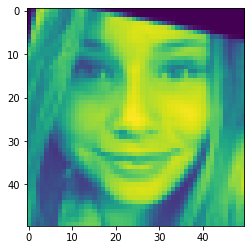

In [97]:
plt.imshow(xtrain[300,:,:])
plt.show()

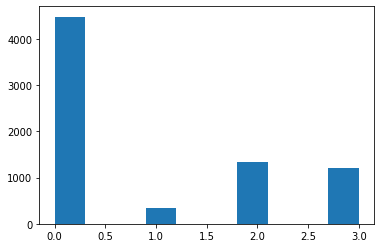

In [98]:
plt.hist(ytrain)
plt.show()

In [99]:
class ImageDataset(Dataset):
    def __init__(self):
        xtrain = np.load("Xtrain_Classification_Part2.npy")
        ytrain = np.load("Ytrain_Classification_Part2.npy")
        xtest = np.load("Xtest_Classification_Part2.npy")


        xtrain_len = len(xtrain)
        ytrain_len = len(ytrain)
        xtest_len = len(xtest)

        #Reshape Images
        xtrain = xtrain.reshape((xtrain_len,50,50))
        #mean = xtrain.mean(axis=(0, 1, 2)) 
        #std = xtrain.std(axis=(0, 1, 2))

        #xtrain = (xtrain - mean)/std  
        
        #xtrain, ytrain = augment_data(xtrain, ytrain)
        
        #new_xtrain_len = len(xtrain)
       # new_ytrain_len = len(ytrain)
        
        self.xtrain = xtrain.reshape((xtrain_len,1,50,50))
        self.xtest = xtest.reshape((xtest_len,1,50,50))

        self.ytrain = ytrain.reshape(ytrain_len)

    def __len__(self):
        return len(self.xtest)

    def __getitem__(self, idx):
 
        
        image = self.xtest[idx, :, :, :]
        label = self.ytrain[idx]
        

        return image, label
    

In [100]:
class ClassifyNet(nn.Module):

    def __init__(self):
        super(ClassifyNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10,
                              kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20,
                              kernel_size=5, stride=1)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(in_features=1620, out_features=400)
        self.fc2 = nn.Linear(in_features=400, out_features=4)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        
        #print(x.shape)
        
        x = x.view(x.shape[0], -1)
        
        #x = self.dropout(x)
        
        #print(x.shape)
        
        x = self.fc1(x)
        x = F.relu(x)
        
        #x = self.dropout(x)
        
        x = self.fc2(x)
        print(x.shape)
        print(x)
        x = torch.softmax(x, dim=4)
        return x

In [101]:
config = {
    'batch_size' : 16,
    'lr' : 0.001,
    'momentum' : 0.9
}

In [102]:
def train_model(model):
    
    num_epochs = 400
    best_score = 1.0
    
    for epoch in range(num_epochs):
        
        model.train()
        running_loss = 0.0
        
        criterion = nn.BCELoss()
        
        for idx, data in enumerate(train_loader):
            image, label = data[0].float().to(device), data[1].float()
            
            
            optimizer.zero_grad()
            
            classify_output = model(image)
            
            print(classify_output[0].sum())
                
            #print(label.shape)
            
            #print(label)
            
            
            
            
            y_true = torch.sigmoid(torch.reshape(label.cpu(), (-1,)))
            y_pred = torch.reshape(classify_output.cpu(), (-1,))
            
            
            loss = criterion(y_pred, y_true)

            #print(loss)

            loss.backward()
            optimizer.step()
            
            # print for mini batches
            running_loss += loss.item()
            if idx % 50 == 49:  # every 50 mini batches
                print('[Epoch %d, %5d Mini Batches] loss: %.3f' %
                      (epoch + 1, idx + 1, running_loss/50))
                running_loss = 0.0
        
        """
        model.eval()
        test_score = 0.0
        
         
        with torch.no_grad():
            for idx, data in enumerate(test_loader):
                image, label = data[0].float().to(device), data[1].float()

                classify_output = model(image)

                y_true = torch.sigmoid(torch.reshape(label.cpu(), (-1,)))
                y_pred = torch.reshape(classify_output.cpu(), (-1,))


                test_loss = criterion(y_pred, y_true)

                test_score += test_loss

            test_score /= len(test_loader)

            #print(test_score)

            if test_score < best_score:
                torch.save(model, "ClassifyNet.pth")
                best_score = test_score
        """

In [103]:
data_set = ImageDataset()

#train_set, test_set = train_test_split(data_set, test_size=0.2, random_state=1, shuffle=True)

train_loader = DataLoader(data_set, batch_size=config['batch_size'], shuffle=True)
#test_loader = DataLoader(test_set, batch_size=config['batch_size'], shuffle=True)

In [104]:
torch.cuda.empty_cache()

In [105]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device= torch.device('cpu')
model = ClassifyNet().to(device)

optimizer = optim.SGD(model.parameters(), lr=config['lr'], momentum=config['momentum'])

In [106]:
train_model(model)

torch.Size([16, 4])
tensor([[-0.6068,  6.3544,  1.2672,  0.2825],
        [-0.0320,  9.6913,  2.8024,  0.5441],
        [ 0.8654,  7.1175,  1.6293, -0.4472],
        [-1.4504,  7.0286,  0.5506,  0.2335],
        [-0.8982,  5.9611,  2.0778,  0.7685],
        [ 0.1500,  8.3988,  1.2781,  0.6121],
        [-0.6373,  5.8276,  2.1170,  0.9787],
        [ 0.4916,  5.7092, -0.0980, -0.1107],
        [ 0.3059,  6.3383, -0.1116,  0.1501],
        [ 0.0809,  7.9204,  1.4743,  0.2250],
        [-1.3735,  7.3829,  2.2696,  0.6063],
        [ 0.6025,  6.5309,  1.4950, -1.2021],
        [-0.8856,  7.8291,  3.0232, -0.5842],
        [-0.5636,  4.5333,  1.4945, -0.5334],
        [-0.6433,  9.1615,  2.6116,  0.2186],
        [-0.9558,  6.9344,  1.0777, -0.1303]], grad_fn=<AddmmBackward>)


IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 4)

In [ ]:

test_set = ImageDataset()
print(len(train_set))

test_loader = DataLoader(test_set, batch_size=1, shuffle=False)


In [ ]:
# Test model against training data

model = torch.load("ClassifyNet.pth")

predictions = np.zeros((len(test_set)))

output = []
with torch.no_grad():
    for idx, data in enumerate(test_loader):
        image = data[0].float().to(device)
        classify_output = model(image)
    
        y_pred = (torch.reshape(classify_output.cpu(), (-1,)) > 0.5).numpy()
        
        predictions[idx] = y_pred



In [ ]:
np.save("predictions.npy", predictions)
